# Test on Real Data

In [1]:
import os.path as op
import sys
sys.path.append(op.abspath('../'))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import models
import var, fcts

from project import files, defs, col, normalize
from lib import data, plot as lp, bdt as lBDT

import hdbscan

In [3]:
import lib.rootdata as lrd
import lib.plot as lp

In [4]:
run = "00405127"
num = "0644" # id of the file for the given run

# Eta and layer to keep
# eta = 0.05
# layer = 0
eta = None
layer = 2

In [5]:
file_path = files.get_path_run_num(run=run, num=num)

# Given {rapidity} and given {layer}
dataframe = lrd.load_ROOT_into_dataframe(
    file_path, 
    tree_name=defs.unproc_tree_name,
    variables=defs.unproc_kept_variables,
    cut=files.get_cut(eta=eta, layer=layer),
)

/mnt/c/900GeV/
Number of events in the dataframe 5819520
Time taken to load the ROOT files: 34.87145018577576
ROOT files loaded: /mnt/c/900GeV/00405127/atlas/data21_900GeV.00405127.physics_L1Calo.merge.RAW._lb0644._SFO-ALL._0001.root


In [8]:
dataframe = files.process_dataframe(dataframe).sample(100000)
dataframe = normalize.normalise_df(dataframe)
dataframe = files.compute_voi(
    dataframe,
    ['std_pos', 'std_neg'])

Remove NaN events
5196 events removed out of 5819520 -> efficiency 0.0008928571428571428
Time taken: 71.46421074867249
Time taken: 0.15061283111572266
Time taken: 0.20449328422546387


In [9]:
dataframe

channelId  layer       eta       phi  ieta  iphi  region        s0  \
5130830  970047488      2  0.962500 -1.132078    38    52       0  0.059028   
5716976  995758080      2  2.312500  2.401191    35    24       1  1.913979   
2661002  984421376      2 -2.487500 -2.106667    42    42       1  0.827170   
1663776  977870848      2 -1.487500  0.053178     2     0       1  0.546711   
3262987  972670464      2  0.987500 -0.052155    39    63       0  0.827170   
...            ...    ...       ...       ...   ...   ...     ...       ...   
5569210  996262912      2  2.062500  2.990240    25    30       1 -0.125988   
4591431  976544768      2 -4.532824  0.990724     7     2       0  0.430331   
2541989  971079168      2  0.537500 -0.641204    21    57       0  1.304989   
680103   980013568      2 -2.112500 -0.241346    27    61       1  0.066965   
4234876  966367744      2  0.712500 -2.408350    28    39       0  0.045691   

               s1        s2  ...       s26       s27       s28       s29  \
5130830  0.059028  0.059028  ...  0.059028 -1.829872 -1.829872  0.059028   
5716976  1.913979 -0.354441  ... -0.354441 -2.622860 -0.354441 -0.354441   
2661002 -1.208941 -1.208941  ... -1.208941  0.827170 -1.208941  0.827170   
1663776 -1.397151  0.546711  ...  0.546711  0.546711  0.546711  0.546711   
3262987 -1.208941  0.827170  ... -1.208941  0.827170  0.827170  0.827170   
...           ...       ...  ...       ...       ...       ...       ...   
5569210 -2.141799 -0.125988  ... -0.125988 -0.125988 -0.125988  1.889822   
4591431  0.430331  0.430331  ...  0.430331 -2.323790  0.430331  0.430331   
2541989 -0.365397  1.304989  ...  1.304989 -0.365397 -0.365397 -0.365397   
680103   0.066965  0.066965  ...  0.066965 -2.075914  0.066965  0.066965   
4234876 -1.416426  0.045691  ... -1.416426  0.045691  0.045691  0.045691   

              s30       s31    old_mean   old_std   std_pos   std_neg  
5130830  0.059028  0.059028   899.96875  0.529409  0.667827  0.746653  
5716976  1.913979 -0.354441   653.15625  0.440835  0.000000  2.159471  
2661002 -1.208941  0.827170   793.59375  0.491132  0.000000  1.297771  
1663776  0.546711 -1.397151   493.71875  0.514440  0.343629  1.086652  
3262987 -1.208941  0.827170   877.59375  0.491132  0.000000  1.297771  
...           ...       ...         ...       ...       ...       ...  
5569210 -0.125988 -0.125988   595.06250  0.496078  0.796819  0.617213  
4591431  0.430331 -2.323790  1365.84375  0.363092  0.000000  1.088662  
2541989 -0.365397 -0.365397   888.21875  0.598664  0.000000  1.644079  
680103   2.209843  0.066965   577.96875  0.466662  0.656120  0.757622  
4234876  0.045691 -1.416426   850.96875  0.683940  0.683843  0.731059  

[100000 rows x 43 columns]

In [10]:
columns_to_compute = ['min_std_pos_neg']
formula_columns = col.get_formula_columns(columns_to_compute)
dataframe = data.compute_vals(dataframe, formula_columns)

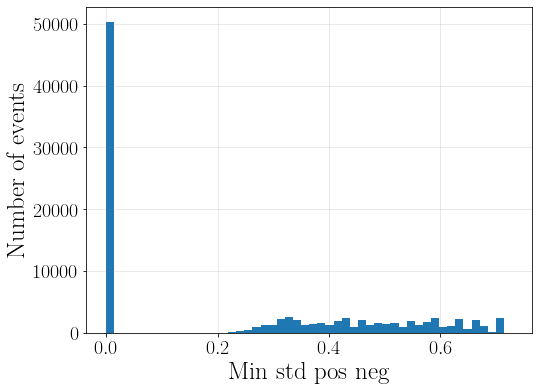

In [11]:
lp.plot_hist(dataframe['min_std_pos_neg'], 'Min std pos neg')
dataframe = dataframe.query('min_std_pos_neg > 0.02')

(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='Min std pos neg', ylabel='Number of events'>)

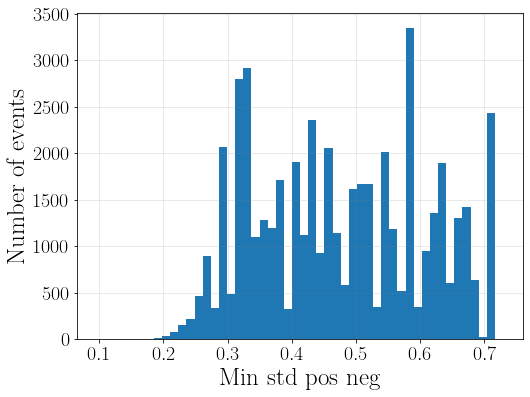

In [12]:
lp.plot_hist(dataframe['min_std_pos_neg'], 'Min std pos neg')

In [14]:
samples_columns = defs.list_samples_columns + ['old_mean','old_std']
df_for_clustering = dataframe[samples_columns]

In [15]:
clusterer = hdbscan.HDBSCAN(min_cluster_size = 200, min_samples = 1, cluster_selection_epsilon = 3)
clusterer.fit(df_for_clustering)

HDBSCAN(cluster_selection_epsilon=3, min_cluster_size=200, min_samples=1)

In [16]:
df_for_clustering['hdbscan'] = clusterer.labels_

/tmp/ipykernel_360/1820477927.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_clustering['hdbscan'] = clusterer.labels_


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='Hdbscan Labels', ylabel='Number of events'>)

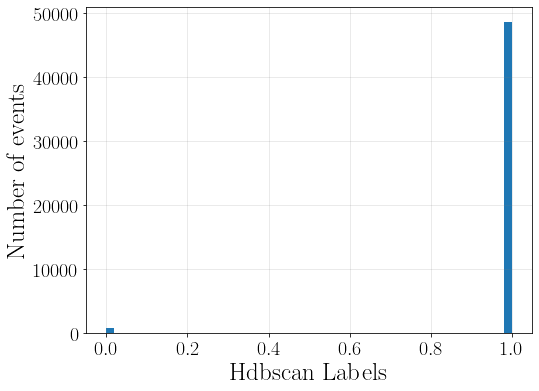

In [32]:
lp.plot_hist(df_for_clustering['hdbscan'], 'Hdbscan Labels')

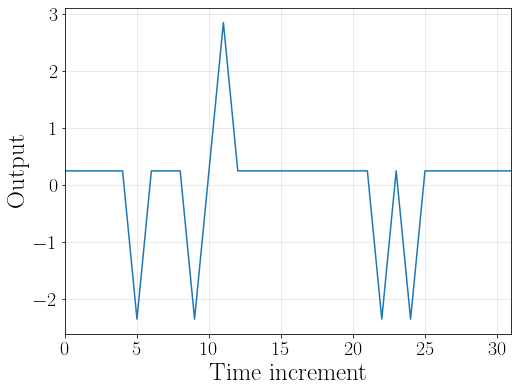

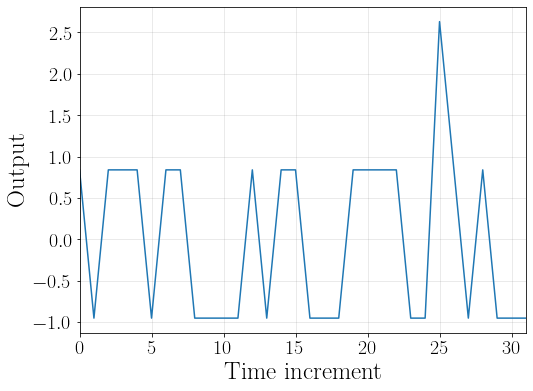

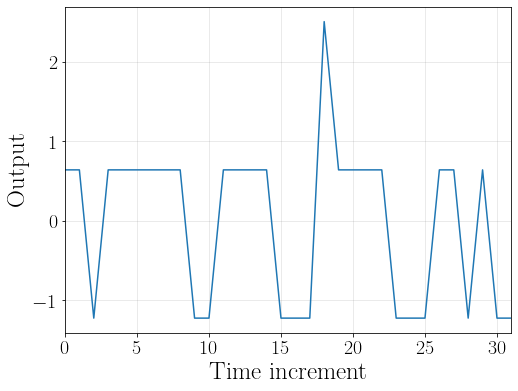

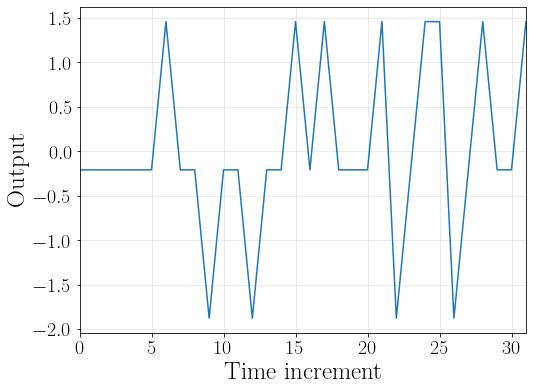

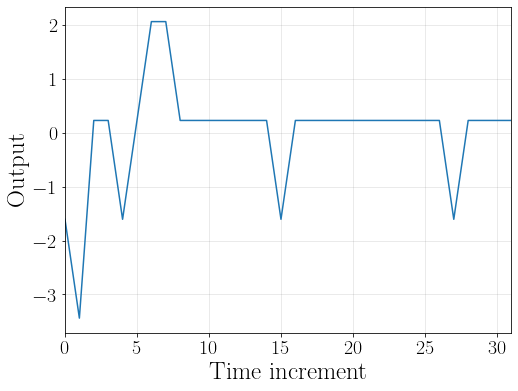

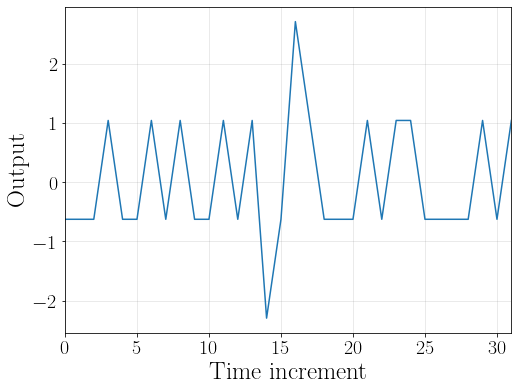

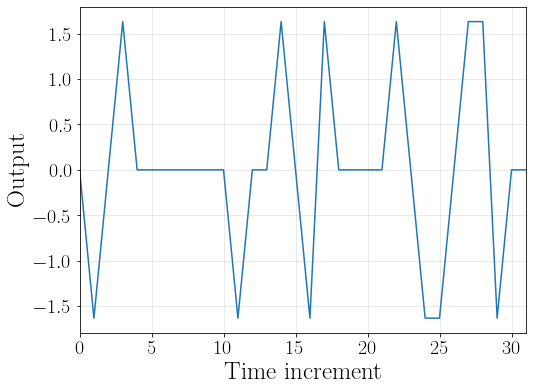

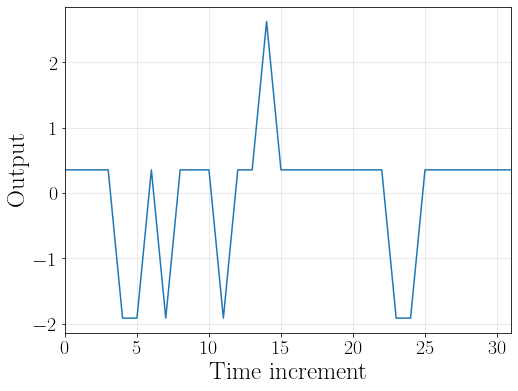

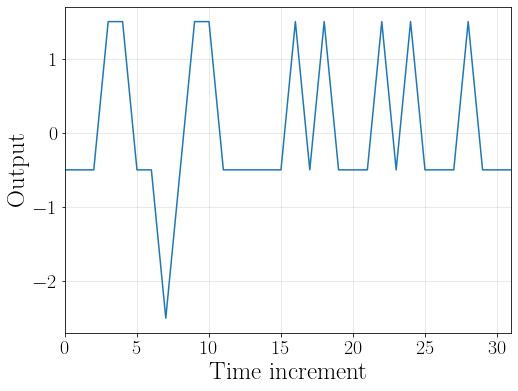

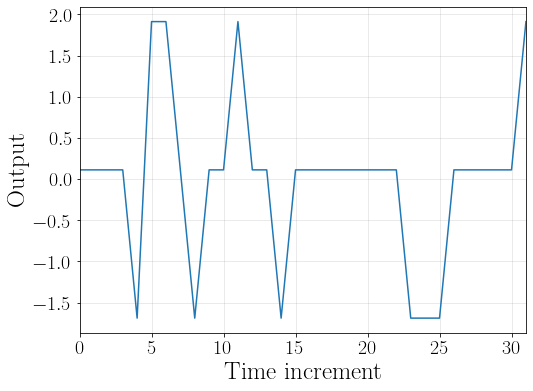

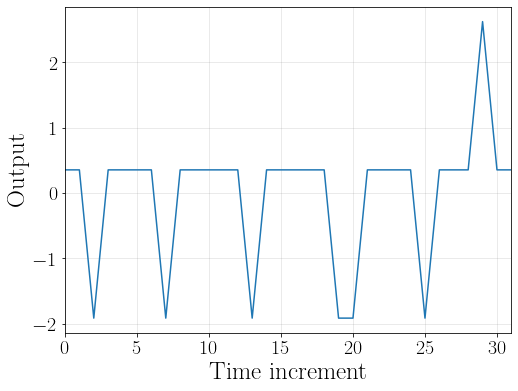

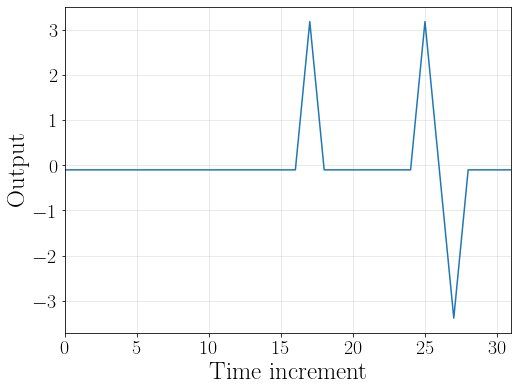

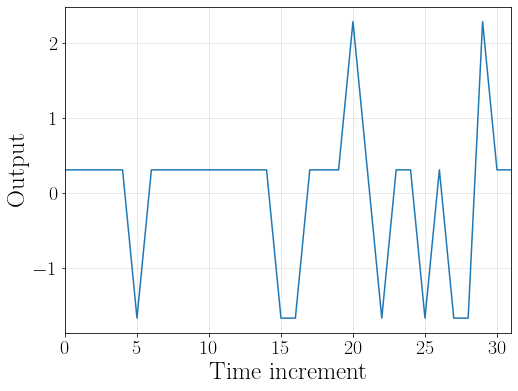

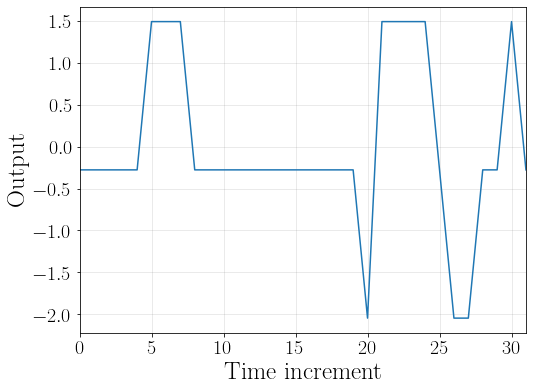

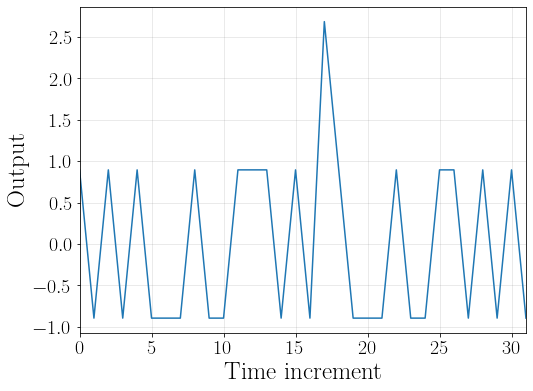

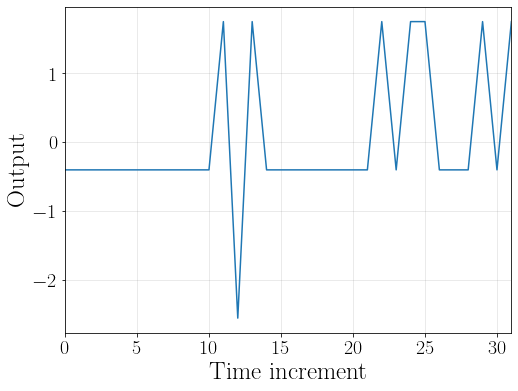

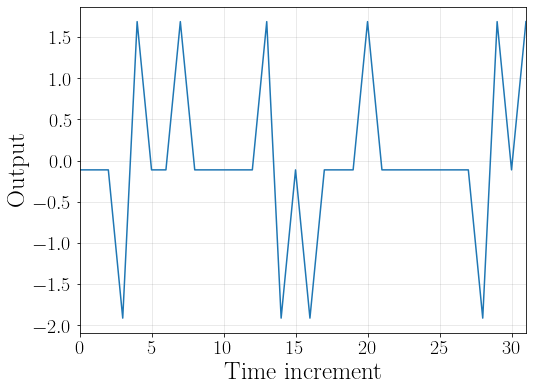

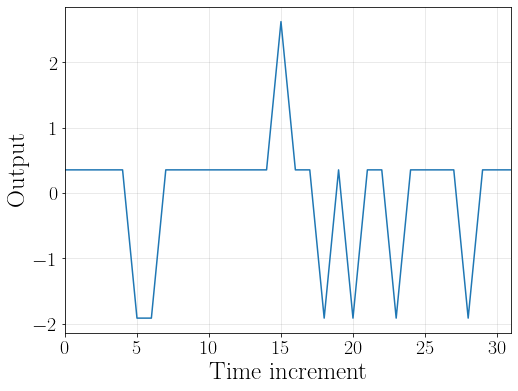

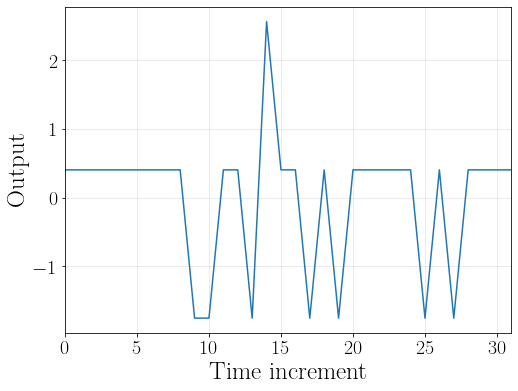

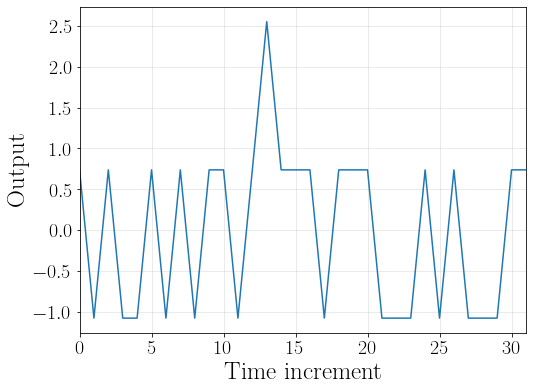

In [65]:
for i in range(20):
    lp.plot_event(df_for_clustering.query("hdbscan == 0").iloc[i])

## New parameters

In [28]:
df_for_clustering2 = dataframe[samples_columns]

In [35]:
clusterer2 = hdbscan.HDBSCAN(min_cluster_size = 10, min_samples = 1, cluster_selection_epsilon = 1)
clusterer2.fit(df_for_clustering2)

HDBSCAN(cluster_selection_epsilon=1, min_cluster_size=10, min_samples=1)

In [36]:
df_for_clustering2['hdbscan'] = clusterer2.labels_

/tmp/ipykernel_360/946678769.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_clustering2['hdbscan'] = clusterer2.labels_


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='Hdbscan Labels', ylabel='Number of events'>)

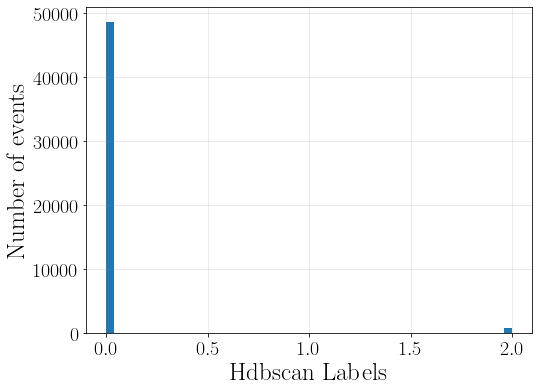

In [37]:
lp.plot_hist(df_for_clustering2['hdbscan'], 'Hdbscan Labels')

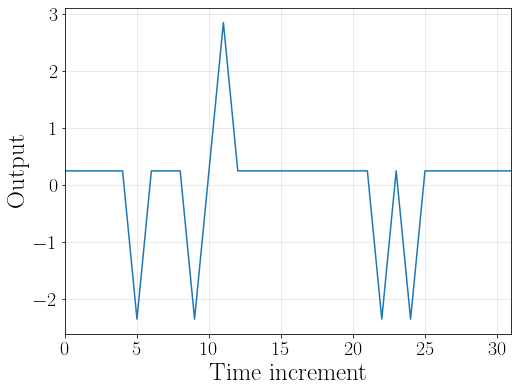

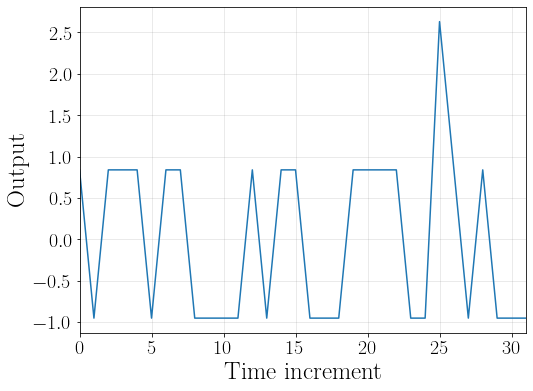

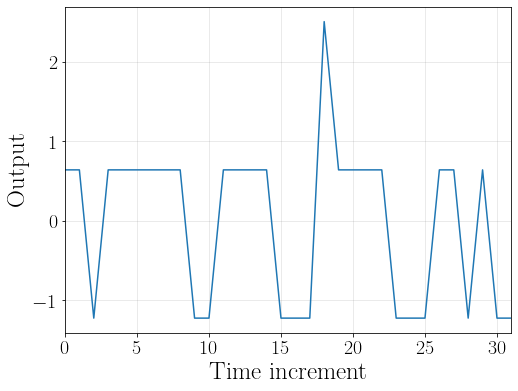

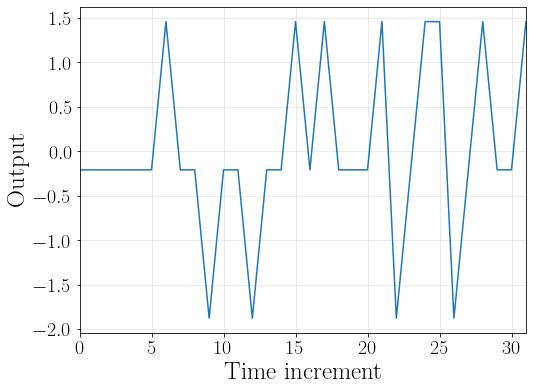

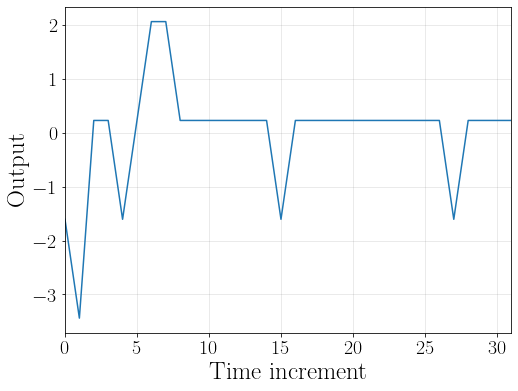

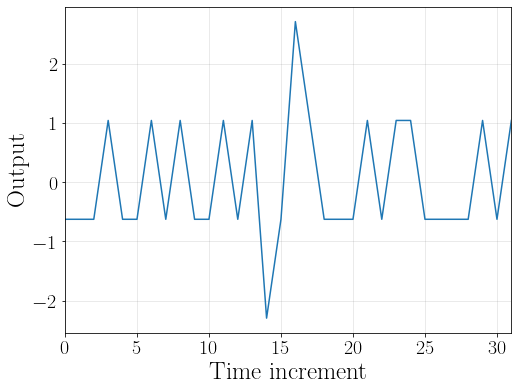

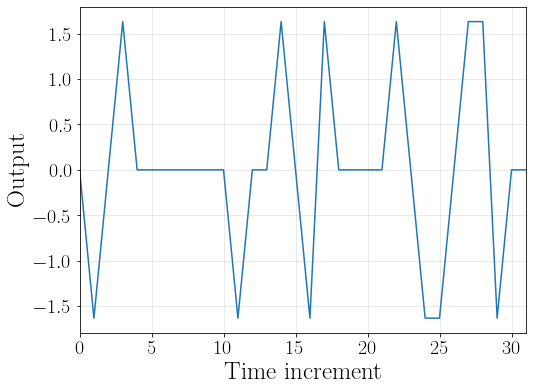

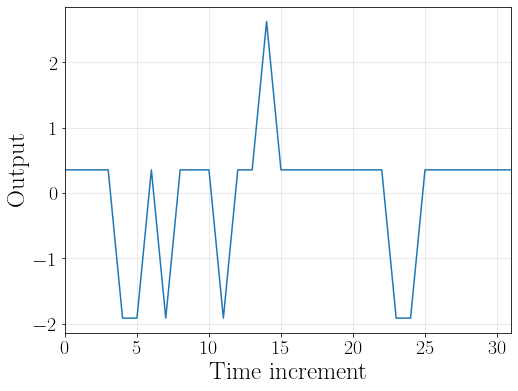

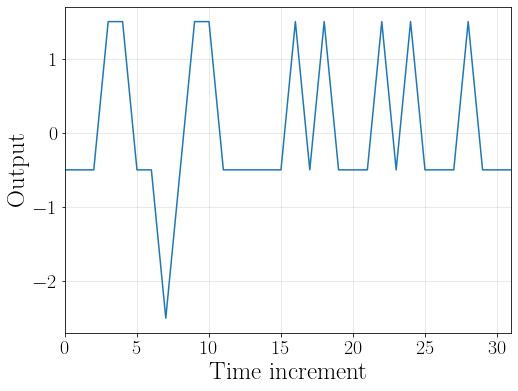

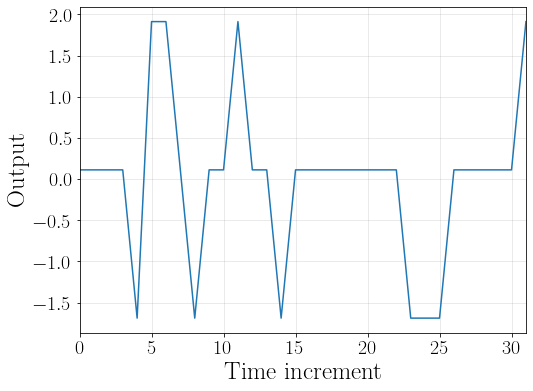

In [48]:
for i in range(10):
    lp.plot_event(df_for_clustering2.query("hdbscan == 2").iloc[i])

## New parameters

In [56]:
df_for_clustering4 = dataframe[samples_columns]
clusterer4 = hdbscan.HDBSCAN(min_cluster_size = 10, min_samples = 1, cluster_selection_epsilon = 0.2)
clusterer4.fit(df_for_clustering4)

HDBSCAN(cluster_selection_epsilon=0.2, min_cluster_size=10, min_samples=1)

/tmp/ipykernel_360/3463166684.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_clustering4['hdbscan'] = clusterer4.labels_


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='Hdbscan Labels', ylabel='Number of events'>)

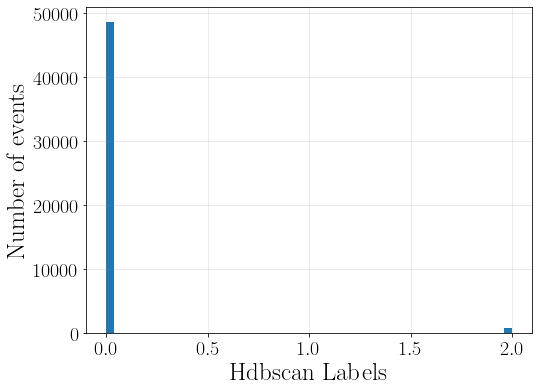

In [57]:
df_for_clustering4['hdbscan'] = clusterer4.labels_
lp.plot_hist(df_for_clustering4['hdbscan'], 'Hdbscan Labels')

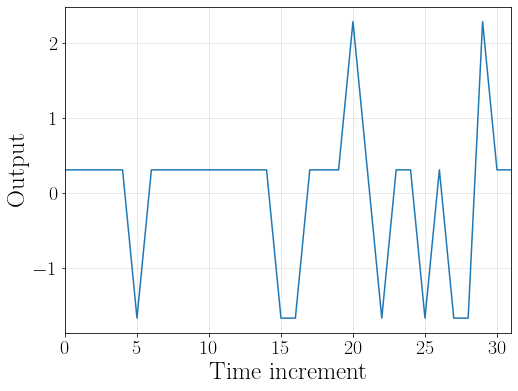

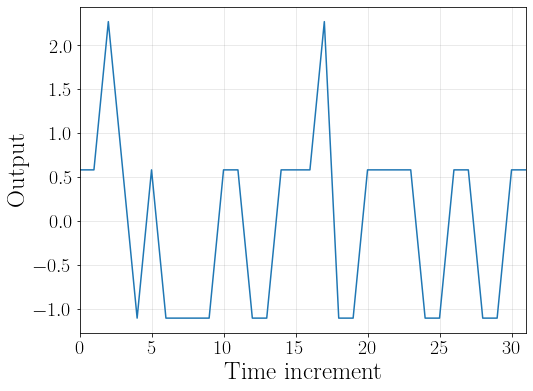

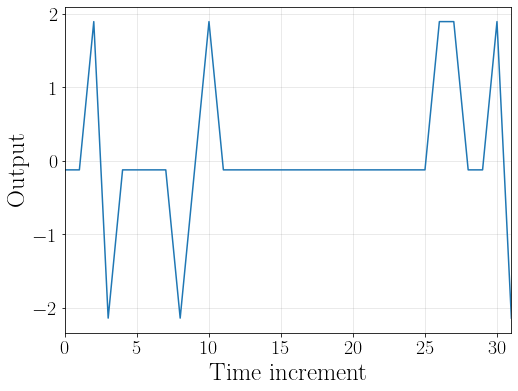

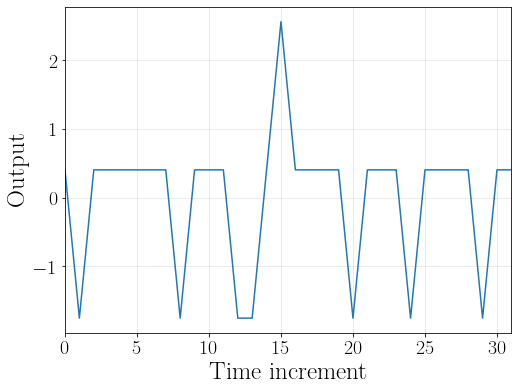

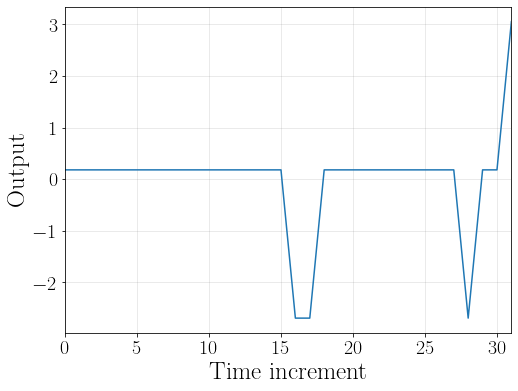

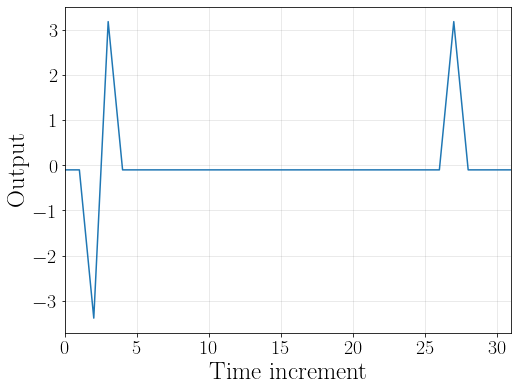

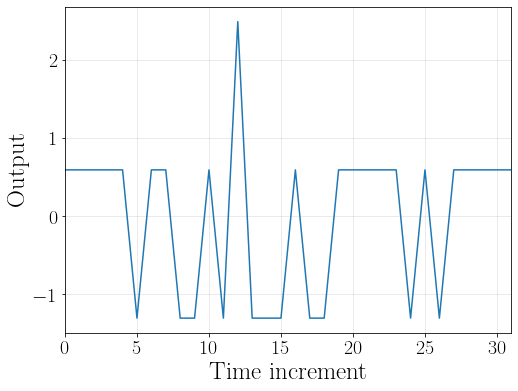

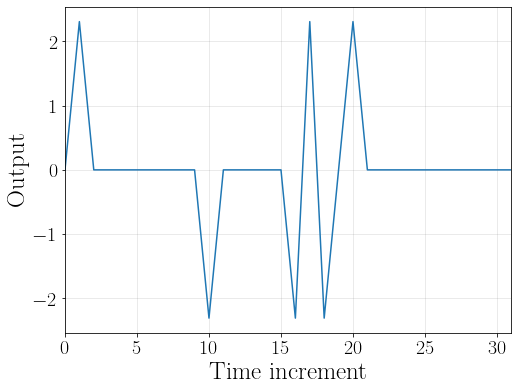

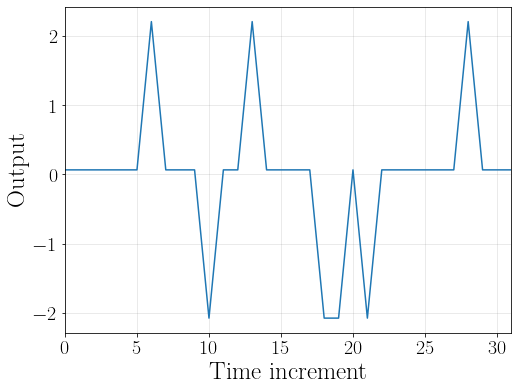

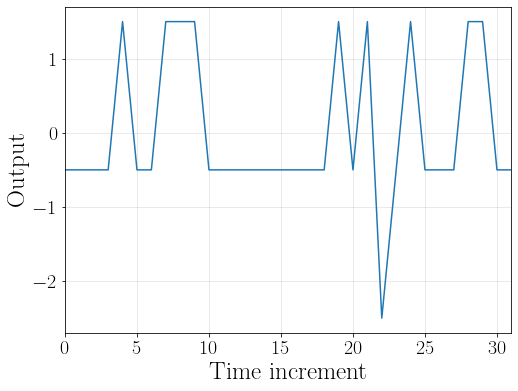

In [59]:
for i in range(10):
    lp.plot_event(df_for_clustering4.query("hdbscan == 1").iloc[i])